In [1]:
import tensorflow as tf
import cv2
import keras
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import ModelCheckpoint
import pickle

2024-06-02 21:35:37.975010: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Data Augmentations
def fliplr(image):
    image = cv2.flip(image, 1)
    return image

def flipud(image):
    image = cv2.flip(image, 0)
    return image

In [3]:
target_height, target_width = 36, 36
number_of_classes = 2

def load_and_preprocess(image_path):
    img = cv2.imread(image_path) # 3 channel image
    if img is None:
        print('Error loading image: ', f'{image_path}')
        return None
    print("Original image size: ", f'{img.shape}')
    img = cv2.resize(img, (target_height, target_width))
    print("New image size: ", f'{img.shape}')
    img = img.astype('float32') / 255 # Normalize pixel values
    return img

In [4]:
def load_and_preprocess2(image_path):
    img = cv2.imread(image_path) # 3 channel image
    if img is None:
        print('Error loading image: ', f'{image_path}')
        return None
    print("Original image size: ", f'{img.shape}')
    image = cv2.imread(image_path, cv2.COLOR_BGR2LAB)
    crop = img
    image = cv2.resize(img, (500, 500))
    L, a, b = cv2.split(image)
    kernel_size = 20

    kernel_v = np.zeros((kernel_size, kernel_size))
    kernel_h = np.copy(kernel_v)
    kernel_d1 = np.copy(kernel_v)
    kernel_d2 = np.copy(kernel_v)

    kernel_v[:, int((kernel_size - 1)/2)] = np.ones(kernel_size)
    kernel_h[int((kernel_size - 1)/2), :] = np.ones(kernel_size)

    for i in range(kernel_size):
        kernel_d1[i, i] = 1

    for i in range(kernel_size):
        kernel_d2[i, kernel_size - i - 1] = 1

    kernel_v /= kernel_size
    kernel_h /= kernel_size
    kernel_d1 /= kernel_size
    kernel_d2 /= kernel_size

    vertical_mb = cv2.filter2D(b, -1, kernel_v)

    horizonal_mb = cv2.filter2D(b, -1, kernel_h)

    d1_mb = cv2.filter2D(b, -1, kernel_d1)

    d2_mb = cv2.filter2D(b, -1, kernel_d2)

    combined_blur = cv2.addWeighted(vertical_mb, 0.25, horizonal_mb, 0.25, 0)
    combined_blur = cv2.addWeighted(combined_blur, 0.5, d1_mb, 0.25, 0)
    img = cv2.addWeighted(combined_blur, 0.5, d2_mb, 0.25, 0)

    gimg = img
    max_brightness_pixel = np.unravel_index(np.argmax(gimg), gimg.shape)
    max_brightness_x, max_brightness_y = max_brightness_pixel

    padding_size = 70
    start_y = max(0, max_brightness_y - padding_size)
    end_y = min(img.shape[0], max_brightness_y + padding_size)
    start_x = max(0, max_brightness_x - padding_size)
    end_x = min(img.shape[1], max_brightness_x + padding_size)

    crop = crop[start_x:end_x, start_y:end_y ]

    img = cv2.resize(crop, (target_height, target_width))
    img = img.astype('float32') / 255 # Normalize pixel values
    return img

In [5]:
x_train = []
x_test = []

y_train = []
y_test =[]

images = []
labels = []


Load REFUGE 96%

In [6]:
import json

with open(r"/home/vijay/project/data/gldata/REFUGE/val/index.json") as f:
    data = json.load(f)

df = pd.DataFrame.from_dict(data, orient='index')
df_refuge1 = df[['ImgName', 'Label']]


/tmp/ipykernel_852875/2168495429.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_id = row[0]
/tmp/ipykernel_852875/2168495429.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[1]


/home/vijay/project/data/gldata/REFUGE/val/Images_Cropped/V0001.jpg
Original image size:  (254, 254, 3)
New image size:  (36, 36, 3)
/home/vijay/project/data/gldata/REFUGE/val/Images_Cropped/V0002.jpg
Original image size:  (274, 274, 3)
New image size:  (36, 36, 3)
/home/vijay/project/data/gldata/REFUGE/val/Images_Cropped/V0003.jpg
Original image size:  (277, 277, 3)
New image size:  (36, 36, 3)
/home/vijay/project/data/gldata/REFUGE/val/Images_Cropped/V0004.jpg
Original image size:  (260, 260, 3)
New image size:  (36, 36, 3)
/home/vijay/project/data/gldata/REFUGE/val/Images_Cropped/V0005.jpg
Original image size:  (226, 226, 3)
New image size:  (36, 36, 3)
/home/vijay/project/data/gldata/REFUGE/val/Images_Cropped/V0006.jpg
Original image size:  (281, 281, 3)
New image size:  (36, 36, 3)
/home/vijay/project/data/gldata/REFUGE/val/Images_Cropped/V0007.jpg
Original image size:  (234, 234, 3)
New image size:  (36, 36, 3)
/home/vijay/project/data/gldata/REFUGE/val/Images_Cropped/V0008.jpg
O

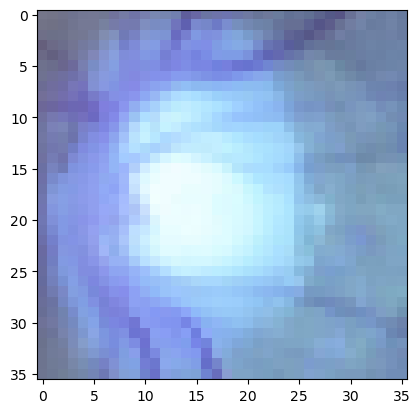

In [7]:
import os
for index , row in df_refuge1.iterrows():
    image_id = row[0]
    label = row[1]

    image_path = os.path.join(r"/home/vijay/project/data/gldata/REFUGE/val/Images_Cropped/", f'{image_id}')
    print(image_path)
    image = load_and_preprocess(image_path)
    if image is not None:
        images.append(image)
        labels.append(label)
        plt.imshow(image)
        if label == 1:
          # fliplr
          image2 = fliplr(image)
          images.append(image2)
          labels.append(label)
          """

          # flipud
          image3 = flipud(image)
          images.append(image3)
          labels.append(label)"""

In [8]:
with open(r"/home/vijay/project/data/gldata/REFUGE/train/index.json") as f:
    data = json.load(f)

df = pd.DataFrame.from_dict(data, orient='index')
df_refuge2 = df[['ImgName', 'Label']]


/tmp/ipykernel_852875/1461805699.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_id = row[0]
/tmp/ipykernel_852875/1461805699.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[1]


/home/vijay/project/data/gldata/REFUGE/train/Images_Cropped/g0001.jpg
Original image size:  (354, 354, 3)
New image size:  (36, 36, 3)
/home/vijay/project/data/gldata/REFUGE/train/Images_Cropped/g0002.jpg
Original image size:  (345, 345, 3)
New image size:  (36, 36, 3)
/home/vijay/project/data/gldata/REFUGE/train/Images_Cropped/g0003.jpg
Original image size:  (280, 280, 3)
New image size:  (36, 36, 3)
/home/vijay/project/data/gldata/REFUGE/train/Images_Cropped/g0004.jpg
Original image size:  (259, 259, 3)
New image size:  (36, 36, 3)
/home/vijay/project/data/gldata/REFUGE/train/Images_Cropped/g0005.jpg
Original image size:  (353, 353, 3)
New image size:  (36, 36, 3)
/home/vijay/project/data/gldata/REFUGE/train/Images_Cropped/g0006.jpg
Original image size:  (345, 345, 3)
New image size:  (36, 36, 3)
/home/vijay/project/data/gldata/REFUGE/train/Images_Cropped/g0007.jpg
Original image size:  (343, 343, 3)
New image size:  (36, 36, 3)
/home/vijay/project/data/gldata/REFUGE/train/Images_Cro

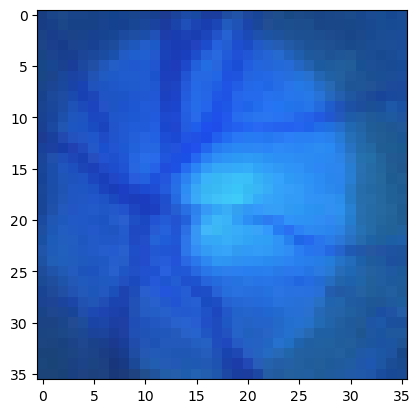

In [9]:
import os
for index , row in df_refuge2.iterrows():
    image_id = row[0]
    label = row[1]

    image_path = os.path.join(r"/home/vijay/project/data/gldata/REFUGE/train/Images_Cropped/", f'{image_id}')
    print(image_path)
    image = load_and_preprocess(image_path)
    if image is not None:
        images.append(image)
        labels.append(label)
        plt.imshow(image)
        if label == 1:
          # fliplr
          image2 = fliplr(image)
          images.append(image2)
          labels.append(label)
          """

          # flipud
          image3 = flipud(image)
          images.append(image3)
          labels.append(label)"""

Load Acrima 99%

In [10]:
df_test = pd.read_csv(r'/home/vijay/project/data/gldata/TestGlaucoma.csv', header=None, skiprows=1)
df_train = pd.read_csv(r'/home/vijay/project/data/gldata/TrainGlaucoma.csv', header=None, skiprows=1)

In [11]:
def load_and_preprocess3(image_path):
    img = cv2.imread(image_path) # 3 channel image
    if img is None:
        print('Error loading image: ', f'{image_path}')
        return None
    print("Original image size: ", f'{img.shape}')
    img = cv2.resize(img, (320, 320))
    img = img[72:248, 72:248]
    img = cv2.resize(img, (target_height, target_width))
    print("new image size: ", f'{img.shape}')
    img = img.astype('float32') / 255 # Normalize pixel values
    return img

In [12]:
for index, row in df_train.iterrows():
    image_id = row[0]
    label = row[1]
    print(image_id, label)

    if label == 1:
        image_path = os.path.join(r'/home/vijay/project/data/gldata/ACRIMA/Training/glaucoma',f'{image_id}')
    else: # For Normal
        image_path = os.path.join(r'/home/vijay/project/data/gldata/ACRIMA/Training/normal', f'{image_id}')
    print(image_path)
    image = load_and_preprocess3(image_path)
    if image is not None:
        images.append(image)
        labels.append(label)
        if label == 1:
            image2 = fliplr(image)
            images.append(image2)
            labels.append(label)
    
            image3 = flipud(image)
            images.append(image3)
            labels.append(label)


Im185_ACRIMA.jpg 0
/home/vijay/project/data/gldata/ACRIMA/Training/normal/Im185_ACRIMA.jpg
Original image size:  (307, 307, 3)
new image size:  (36, 36, 3)
Im002_ACRIMA.jpg 0
/home/vijay/project/data/gldata/ACRIMA/Training/normal/Im002_ACRIMA.jpg
Original image size:  (277, 277, 3)
new image size:  (36, 36, 3)
Im425_g_ACRIMA.jpg 1
/home/vijay/project/data/gldata/ACRIMA/Training/glaucoma/Im425_g_ACRIMA.jpg
Original image size:  (298, 298, 3)
new image size:  (36, 36, 3)
Im180_ACRIMA.jpg 0
/home/vijay/project/data/gldata/ACRIMA/Training/normal/Im180_ACRIMA.jpg
Original image size:  (355, 355, 3)
new image size:  (36, 36, 3)
Im409_g_ACRIMA.jpg 1
/home/vijay/project/data/gldata/ACRIMA/Training/glaucoma/Im409_g_ACRIMA.jpg
Original image size:  (454, 454, 3)
new image size:  (36, 36, 3)
Im332_g_ACRIMA.jpg 1
/home/vijay/project/data/gldata/ACRIMA/Training/glaucoma/Im332_g_ACRIMA.jpg
Original image size:  (244, 244, 3)
new image size:  (36, 36, 3)
Im230_ACRIMA.jpg 0
/home/vijay/project/data/gl

In [13]:
for index, row in df_test.iterrows():
    image_id = row[0]
    label = row[1]
    print(image_id, '-', label)

    if label == 1: # For glaucome
        image_path = os.path.join(r'/home/vijay/project/data/gldata/ACRIMA/Testing/glaucoma',f'{image_id}')
    else: # For Normal
        image_path = os.path.join(r'/home/vijay/project/data/gldata/ACRIMA/Testing/normal', f'{image_id}')
    print(image_path)
    image = load_and_preprocess3(image_path)
    if image is not None:
        images.append(image)
        labels.append(label)
        if label == 1:
            image2 = fliplr(image)
            images.append(image2)
            labels.append(label)
    
            image3 = flipud(image)
            images.append(image3)
            labels.append(label)


Im661_g_ACRIMA.jpg - 1
/home/vijay/project/data/gldata/ACRIMA/Testing/glaucoma/Im661_g_ACRIMA.jpg
Original image size:  (853, 853, 3)
new image size:  (36, 36, 3)
Im628_g_ACRIMA.jpg - 1
/home/vijay/project/data/gldata/ACRIMA/Testing/glaucoma/Im628_g_ACRIMA.jpg
Original image size:  (814, 814, 3)
new image size:  (36, 36, 3)
Im260_ACRIMA.jpg - 0
/home/vijay/project/data/gldata/ACRIMA/Testing/normal/Im260_ACRIMA.jpg
Original image size:  (313, 313, 3)
new image size:  (36, 36, 3)
Im289_ACRIMA.jpg - 0
/home/vijay/project/data/gldata/ACRIMA/Testing/normal/Im289_ACRIMA.jpg
Original image size:  (343, 343, 3)
new image size:  (36, 36, 3)
Im672_g_ACRIMA.jpg - 1
/home/vijay/project/data/gldata/ACRIMA/Testing/glaucoma/Im672_g_ACRIMA.jpg
Original image size:  (901, 901, 3)
new image size:  (36, 36, 3)
Im699_g_ACRIMA.jpg - 1
/home/vijay/project/data/gldata/ACRIMA/Testing/glaucoma/Im699_g_ACRIMA.jpg
Original image size:  (1036, 1036, 3)
new image size:  (36, 36, 3)
Im264_ACRIMA.jpg - 0
/home/vijay

Load ORIGA 80%

Load RIM ONE 94%

In [14]:
df_testr = pd.read_csv('/home/vijay/project/data/gldata/RimTestGlaucoma.csv', header=None, skiprows=1)
df_trainr = pd.read_csv('/home/vijay/project/data/gldata/RimTrainGlaucoma.csv', header=None, skiprows=1)

In [15]:
for index, row in df_trainr.iterrows():
    image_id = row[0]
    label = row[1]
    print(image_id, label)

    if label == 1: # For glaucomeimage_path = os.path.join(r'C:\Users\vs056\OneDrive\Documents\MTECH-Project\Drishti\Training-20211018T055246Z-001\Training\Images\GLAUCOMA',f'{image_id}')
        image_path = os.path.join(r'/home/vijay/project/data/gldata/RIM-ONE/Training/glaucoma',f'{image_id}')
    else: # For Normal
        image_path = os.path.join(r'/home/vijay/project/data/gldata/RIM-ONE/Training/normal', f'{image_id}')
    print(image_path)
    image = load_and_preprocess(image_path)
    if image is not None:
        images.append(image)
        labels.append(label)
        # fliplr
        image2 = fliplr(image)
        images.append(image2)
        labels.append(label)

        # flipud
        image3 = flipud(image)
        images.append(image3)
        labels.append(label)


r3_N-2-R_left_half.png 0
/home/vijay/project/data/gldata/RIM-ONE/Training/normal/r3_N-2-R_left_half.png
Original image size:  (422, 422, 3)
New image size:  (36, 36, 3)
r2_Im186.png 0
/home/vijay/project/data/gldata/RIM-ONE/Training/normal/r2_Im186.png
Original image size:  (672, 672, 3)
New image size:  (36, 36, 3)
r2_Im448.png 1
/home/vijay/project/data/gldata/RIM-ONE/Training/glaucoma/r2_Im448.png
Original image size:  (646, 646, 3)
New image size:  (36, 36, 3)
r3_N-17-L_left_half.png 0
/home/vijay/project/data/gldata/RIM-ONE/Training/normal/r3_N-17-L_left_half.png
Original image size:  (394, 394, 3)
New image size:  (36, 36, 3)
r2_Im357.png 1
/home/vijay/project/data/gldata/RIM-ONE/Training/glaucoma/r2_Im357.png
Original image size:  (728, 728, 3)
New image size:  (36, 36, 3)
r3_N-68-R_left_half.png 0
/home/vijay/project/data/gldata/RIM-ONE/Training/normal/r3_N-68-R_left_half.png
Original image size:  (372, 372, 3)
New image size:  (36, 36, 3)
r3_S-11-L_left_half.png 1
/home/vijay/

In [16]:

for index, row in df_testr.iterrows():
    image_id = row[0]
    label = row[1]
    print(image_id, '-', label)

    if label == 1: # For glaucome
        image_path = os.path.join(r'/home/vijay/project/data/gldata/RIM-ONE/Testing/glaucoma',f'{image_id}')
    else: # For Normal
        image_path = os.path.join(r'/home/vijay/project/data/gldata/RIM-ONE/Testing/normal', f'{image_id}')
    print(image_path)
    image = load_and_preprocess(image_path)
    if image is not None:
        images.append(image)
        labels.append(label)
        # fliplr
        image2 = fliplr(image)
        images.append(image2)
        labels.append(label)

        # flipud
        image3 = flipud(image)
        images.append(image3)
        labels.append(label)



r2_Im021.png - 0
/home/vijay/project/data/gldata/RIM-ONE/Testing/normal/r2_Im021.png
Original image size:  (328, 328, 3)
New image size:  (36, 36, 3)
r1_Im119.png - 0
/home/vijay/project/data/gldata/RIM-ONE/Testing/normal/r1_Im119.png
Original image size:  (414, 414, 3)
New image size:  (36, 36, 3)
r1_Im133.png - 0
/home/vijay/project/data/gldata/RIM-ONE/Testing/normal/r1_Im133.png
Original image size:  (369, 369, 3)
New image size:  (36, 36, 3)
r2_Im319.png - 1
/home/vijay/project/data/gldata/RIM-ONE/Testing/glaucoma/r2_Im319.png
Original image size:  (364, 364, 3)
New image size:  (36, 36, 3)
r1_Im082.png - 0
/home/vijay/project/data/gldata/RIM-ONE/Testing/normal/r1_Im082.png
Original image size:  (422, 422, 3)
New image size:  (36, 36, 3)
r1_Im156.png - 0
/home/vijay/project/data/gldata/RIM-ONE/Testing/normal/r1_Im156.png
Original image size:  (376, 376, 3)
New image size:  (36, 36, 3)
r2_Im001.png - 0
/home/vijay/project/data/gldata/RIM-ONE/Testing/normal/r2_Im001.png
Original imag

Load G1020 68%

In [17]:
# Split data into training and testing sets

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [18]:
# convert list into array
x_train = np.array(x_train)
x_test = np.array(x_test)

In [19]:
# checking input shape
# for gray scale image
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (3065, 36, 36, 3)
3065 train samples
767 test samples


In [20]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, number_of_classes)
y_test = keras.utils.to_categorical(y_test, number_of_classes)

In [21]:

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_trest shape", x_test.shape)
print(y_train.shape[0], "train samples")
print(y_test.shape[0], "test samples")

x_train shape: (3065, 36, 36, 3)
y_train shape: (3065, 2)
x_trest shape (767, 36, 36, 3)
3065 train samples
767 test samples


In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=(19, 19), input_shape=(36, 36, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=64, padding='same', kernel_size=(11, 11)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=64, padding='same', kernel_size=(5, 5)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #tf.keras.layers.Conv2D(filters=250, padding='same', kernel_size=(2, 2)),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.ReLU(),
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(units=128),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(units=2),
    tf.keras.layers.Softmax()
])

model.summary()


/home/vijay/miniconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-02 21:36:01.496979: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79056 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:3b:00.0, compute capability: 8.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 36, 36, 32)     │        34,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 36, 36, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 18, 18, 64)     │       247,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 18, 18, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 64)       │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 9, 9, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 517,122 (1.97 MB)

 Trainable params: 516,802 (1.97 MB)

 Non-trainable params: 320 (1.25 KB)

In [23]:
checkpoint = ModelCheckpoint("/home/vijay/project/glmodels/best_model.keras", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', save_freq="epoch")

In [24]:
optim = keras.optimizers.Nadam(learning_rate = 0.0001)
model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
model.fit(x_train, y_train, epochs=90, batch_size=64, validation_data=(x_test, y_test), callbacks=[checkpoint])

Epoch 1/90


I0000 00:00:1717344365.578602  853310 service.cc:145] XLA service 0x70569c004f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717344365.578646  853310 service.cc:153]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-06-02 21:36:05.701192: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-02 21:36:05.900875: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


36/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6943 - loss: 0.6261

I0000 00:00:1717344369.670447  853310 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7122 - loss: 0.5947

I0000 00:00:1717344374.382278  853737 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_139', 8 bytes spill stores, 8 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.47588, saving model to /home/vijay/project/glmodels/best_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.7135 - loss: 0.5925 - val_accuracy: 0.4759 - val_loss: 0.6855
Epoch 2/90
44/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8549 - loss: 0.3490
Epoch 2: val_accuracy improved from 0.47588 to 0.53716, saving model to /home/vijay/project/glmodels/best_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8547 - loss: 0.3485 - val_accuracy: 0.5372 - val_loss: 0.6786
Epoch 3/90
45/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8656 - loss: 0.3124
Epoch 3: val_accuracy did not improve from 0.53716
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8661 - loss: 0.3115 - val_accuracy: 0.4928 - val_loss: 0.6672
Epoch 4/90
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8907 - loss: 0.2707
Epoch 4: val_accuracy did not improve from 0.53716
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8903 - loss

In [26]:
from keras.models import load_model

best_model = load_model('/home/vijay/project/glmodels/best_model.keras')

# Save the best model for future use
best_model.save('/home/vijay/project/glmodels/best_gl.h5')

In [27]:
predictions = best_model.predict(x_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


In [28]:
binary_predictions = (predictions > 0.5).astype(int)

In [29]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, binary_predictions)

# Print accuracy
print(f"Accuracy on test data: {accuracy:.4f}")


Accuracy on test data: 0.9478


In [30]:
score = best_model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.2580256760120392
Test accuracy: 0.9478487372398376


In [31]:
score = best_model.evaluate(x_train, y_train, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.00012997262820135802
Test accuracy: 1.0


In [32]:
y_pred = model.predict(x_test)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [33]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))


In [34]:
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])


In [35]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_pred.ravel())


In [36]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test.ravel(), y_pred.ravel())


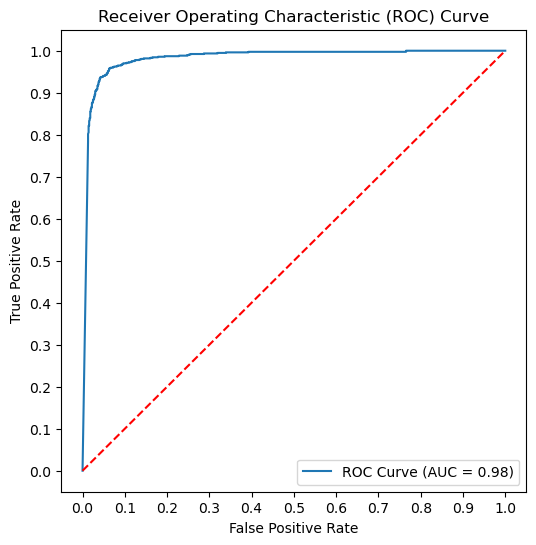

In [37]:
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.legend()
plt.show()


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def calculate_specificity_sensitivity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    return specificity, sensitivity

y_test_single = np.argmax(y_test, axis=1)
y_pred_single = np.argmax(y_pred, axis=1)

specificity, sensitivity = calculate_specificity_sensitivity(y_test_single, y_pred_single)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)

Specificity: 0.9439024390243902
Sensitivity: 0.9411764705882353


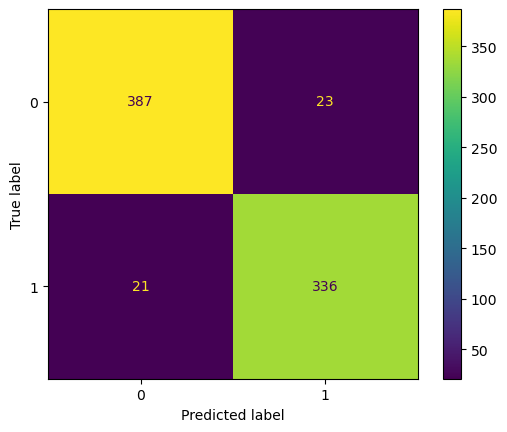

In [39]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test_single, y_pred_single)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()